# Trayendo datos de poloniex y convirtiendolos en dataframe

In [1]:
import pandas as pd
import pylab as plt
from tusp import string2ts, ts2string
from bot import prepareData,marketReturn
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 8

# trayendo y preparando datos
df  = prepareData(pair="BTC_XRP",
                  start=string2ts("2017-07-01 00:00:00"),
                  end=string2ts("2018-03-01 00:00:00"),
                  period=3600*4)
"""
# calculando el retorno del mercado hasta el 4 quitil y del ultimo quintil
df_train = df.loc["2014-09-10 00:00:00":"2017-06-01 00:00:00",:]
df_test = df.loc["2017-06-01 00:00:00":"2017-09-01 00:00:00",:]
"""
per = 0.85
cum_return1 = marketReturn(df[:int(len(df)*per)]["close"])
cum_return2 = marketReturn(df[int(len(df)*per):]["close"]) 
#cum_return1 = marketReturn(df_train)
#cum_return2 = marketReturn(df_test) 

marketReturn = cum_return1[-1]*100 
marketReturn2 = cum_return2[-1]*100

print "Retorno final del mercado: %s"%(marketReturn)
df.head()

Retorno final del mercado: 24.327543424317554


,close,high,low,open,quoteVolume,volume,weightedAverage,volatility
date,,,,,,,,
2017-07-01 00:00:00,0.000101,0.000101,0.000099,0.000101,6804554.152342,682.629027,0.000100,False
2017-07-01 04:00:00,0.000099,0.000101,0.000099,0.000101,7776308.3545149,778.744184,0.000100,True
2017-07-01 08:00:00,0.000099,0.000101,0.000099,0.000099,4414968.642775,439.684562,0.000100,False
2017-07-01 12:00:00,0.000100,0.000100,0.000099,0.000099,5629641.7432203,559.404665,0.000099,False
2017-07-01 16:00:00,0.000099,0.000100,0.000098,0.000100,5427761.1629749,537.959577,0.000099,True


# Creando estrategias, columna con RSI_14 y sus respectivos vectores de peso

profit.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  w['w'] = w['w'].shift(1)
profit.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  w["return"] = vecReturn


Retorno del mercacdo: 24.327543424317554
Retorno de SMA13 VS EMA5: 449.8885908370034
Retorno de Precio VS SMA20: 425.75686134396005
Retorno de Precio VS EMA5: 1003.6253131574236


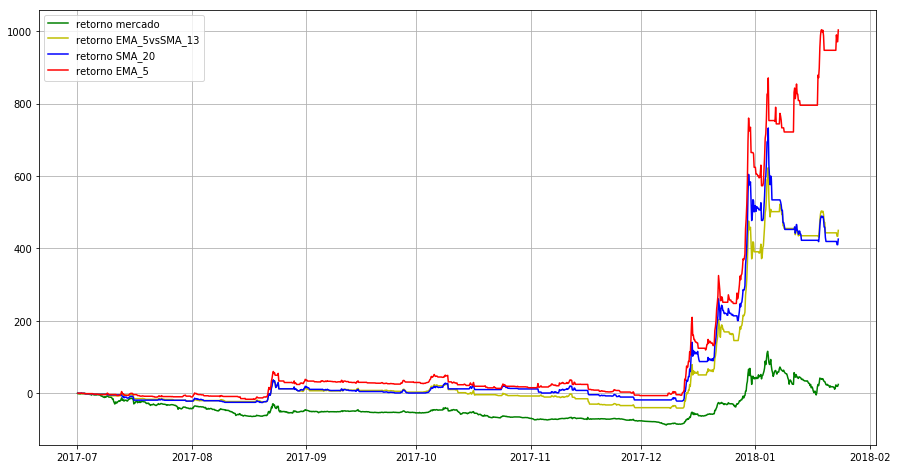

In [2]:
from strategy2 import EMAvsSMA,pricevsEMA, pricevsSMA
from profit import profit

#EMA_5vsSMA_13
w = EMAvsSMA(df['weightedAverage'],13,5)
wTrain = w[:int(len(df)*per)]
wTest = w[int(len(df)*per):]
relativeReturn,v = profit(wTrain)
relativeReturnTest,vTest = profit(wTest)

#Precio vs SMA_20
w3 = pricevsSMA(df['weightedAverage'],20)
w3Train = w3[:int(len(df)*per)]
w3Test = w3[int(len(df)*per):]
relativeReturn3,v3 = profit(w3Train)
relativeReturn3Test,v3Test = profit(w3Test)

#Precio vs EMA_5
# 23.6
w2 = pricevsEMA(df['weightedAverage'])
w2Train = w2[:int(len(df)*per)]
w2Test = w2[int(len(df)*per):]
relativeReturn2,v2 = profit(w2Train)
relativeReturn2Test,v2Test = profit(w2Test)

print 'Retorno del mercacdo: %s'%(marketReturn)
print 'Retorno de SMA13 VS EMA5: %s'%(relativeReturn*100)
print 'Retorno de Precio VS SMA20: %s'%(relativeReturn3*100)
print 'Retorno de Precio VS EMA5: %s'%(relativeReturn2*100)

plt.plot(df.index[:int(len(df)*per)],cum_return1*100,'g', label='retorno mercado')
plt.plot(df.index[:int(len(df)*per)],v*100,'y',label='retorno EMA_5vsSMA_13')
plt.plot(df.index[:int(len(df)*per)],v3*100,'b',label='retorno SMA_20')
plt.plot(df.index[:int(len(df)*per)],v2*100,'r',label='retorno EMA_5')

plt.legend(loc='best')
plt.grid()


## RSI via stockstacks

In [3]:
from stockstats import StockDataFrame

stock = StockDataFrame.retype(df.copy())
stock["rsi_14"];
stock["macd"];
stock["macds"];
stock["cci"];
stock["wr_14"];

/home/Dsiervo/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
c=20
stock = StockDataFrame.retype(df.copy())
volatile = stock["pdi"]>c

stock["volatile"] = volatile
stock[["pdi","volatile"]].head(30)

,pdi,volatile
date,,
2017-07-01 00:00:00,NaN,False
2017-07-01 04:00:00,0.245740,False
2017-07-01 08:00:00,0.150082,False
2017-07-01 12:00:00,0.117444,False
2017-07-01 16:00:00,0.092273,False
2017-07-01 20:00:00,0.067141,False
2017-07-02 00:00:00,20.076138,True
2017-07-02 04:00:00,17.578455,False
2017-07-02 08:00:00,14.574778,False


In [5]:
from peakdetect import peakdetect

y = df['close'].values
x = df.index[:].values

_max, _min = peakdetect(y, x, 3)

xm = [p[0] for p in _max]
ym = [p[1] for p in _max]
xn = [p[0] for p in _min]
yn = [p[1] for p in _min]




## Indicadores via TA-Lib

In [6]:
#import talib

#df["fastk"], df["fastd"] = talib.STOCHRSI(df["close"].values, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)

#plt.subplot(211)
#plot = plt.plot(x, y)
#plt.hold(True)
#plt.plot(xm, ym, "r+")
#plt.plot(xn, yn, "g+")
#plt.subplot(212)
#df["fastk"].plot()
#df["fastd"].plot()

# Preparando DataFrame para ML

## Creando estrategia ideal en base a maximos y minimos

In [7]:
from mldata import ml_data
from orders import orders

df["ml_data"] = ml_data(df["close"],la=10,pl=False)

w4 = pd.DataFrame(data={"w":df["ml_data"].values,"price":df["close"]})
w4["orders"] = orders(w4["w"])
w4["w"] = w4["w"].shift(1)
relReturn, vecReturn4 = profit(w4)
print "Retorno de estrategia ideal: %s"%(relReturn*100)

data = pd.DataFrame(data={"price":df["close"],"pricew":df["weightedAverage"],"volumen":df["volume"],
                          "rsi":stock["rsi_14"],"macd":stock["macd"],"macds":stock["macds"],"cci":stock["cci"],
                          "wr":stock["wr_14"],"ideal_w":w4["w"],"volatility": df["volatility"],"close":df["close"],"kdjk":stock["kdjk"],
                          "kdjd":stock["kdjd"],"kdjj":stock["kdjj"], "dma":stock["dma"], "trix":stock["trix"],
                          "vr":stock["vr"]})

# separando datos para crear y evaluar el modelo de machine learning
train = data[1:int(len(data)*per)]
test = data[int(len(data)*per):]
#train = data.loc["2014-09-10 00:00:00":"2017-06-01 00:00:00",:][1:]
#test = data.loc["2017-06-01 00:00:00":"2017-09-01 00:00:00",:]
train.tail()

Retorno de estrategia ideal: 42805.58138640792


,cci,close,dma,ideal_w,kdjd,kdjj,kdjk,macd,macds,price,pricew,rsi,trix,volatility,volumen,vr,wr
date,,,,,,,,,,,,,,,,,
2018-01-22 20:00:00,53.594940,0.000124,-0.000005,1.0,36.514639,76.925898,49.985059,-0.000003,-0.000002,0.000124,0.000118,52.188082,-0.371616,True,1193.332722,36.812044,16.469120
2018-01-23 00:00:00,114.901357,0.000122,-0.000005,1.0,44.491601,92.353375,60.445526,-0.000002,-0.000002,0.000122,0.000122,50.230005,-0.355745,False,1108.483996,40.238765,18.633540
2018-01-23 04:00:00,57.322808,0.000120,-0.000004,1.0,50.316779,85.267846,61.967134,-0.000002,-0.000002,0.000120,0.000120,47.393459,-0.335701,True,542.760002,45.259988,34.989648
2018-01-23 08:00:00,54.807124,0.000120,-0.000004,1.0,54.630383,80.512011,63.257593,-0.000002,-0.000002,0.000120,0.000120,47.554950,-0.312800,False,558.331852,35.501154,34.161491
2018-01-23 12:00:00,176.899243,0.000125,-0.000003,1.0,59.638420,89.686640,69.654493,-0.000001,-0.000002,0.000125,0.000124,54.137682,-0.273059,True,1068.716270,45.374908,17.551705


# Creando modelo de regresion logistica utilizando sticklearn

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
# Estas dos últimas librerías permiten la creación de una 
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
# "price","volumen","rsi","macd","macds","ideal_w","cci","wr"
features = ["price","rsi","cci","macds","macd","wr","trix","vr"]

# regresion logistica
logreg = LogisticRegression(C=0.150, )

train.replace([np.inf, -np.inf], np.nan, inplace=True)
train.fillna(method='bfill', inplace=True)
# entrenando modelos
logreg.fit(train[features],train["ideal_w"])

/home/Dsiervo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


LogisticRegression(C=0.15, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
# random forests
random_forest = RandomForestClassifier(n_estimators=45, max_depth=4, min_samples_split=65)
random_forest.fit(train[features],train["ideal_w"])

# DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_depth=3, min_samples_split=250, min_samples_leaf=145)
decision_tree.fit(train[features],train["ideal_w"])

# XGBoost
xgb = XGBClassifier(n_estimators=9, learning_rate=0.75, gamma=12)
xgb.fit(train[features],train["ideal_w"])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=12, learning_rate=0.75, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=9,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [10]:
# knn
knn = KNeighborsClassifier(n_neighbors = 30)

knn.fit(train[features],train["ideal_w"])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='uniform')

In [42]:
# Neural network

# MLPClassifier

mlpc = MLPClassifier(solver='lbfgs',random_state=1, hidden_layer_sizes=(9,30))

mlpc.fit(train[features],train["ideal_w"])

# BernoulliRBM

#rbm = BernoulliRBM()
#logistic = LogisticRegression()
#classifier = Pipeline([("rbm",rbm),("logistic",logistic)])
#classifier.fit(train[features],train["ideal_w"])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(9, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

## probando modelo en otros datos

Regresion logistica:
0.817351598173516
random forest:
0.8356164383561644
decision_tree:
0.8493150684931506
xgboost:
0.8447488584474886
Regresion knn:
0.8264840182648402
Regresion mlpc:
0.821917808219178


/home/Dsiervo/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Regresion rbm:
0.8036529680365296
Retorno del mercacdo: -30.321893684986488
Retorno de ML_mlpc: -4.342525267489384
Retorno de ML_Boltzman: 0.0
Retorno de ML_randfor: 8.435756442796261
Retorno de ML_decision_tree: 12.297726144509745
Retorno de ML_xgboost: 15.355059885323552


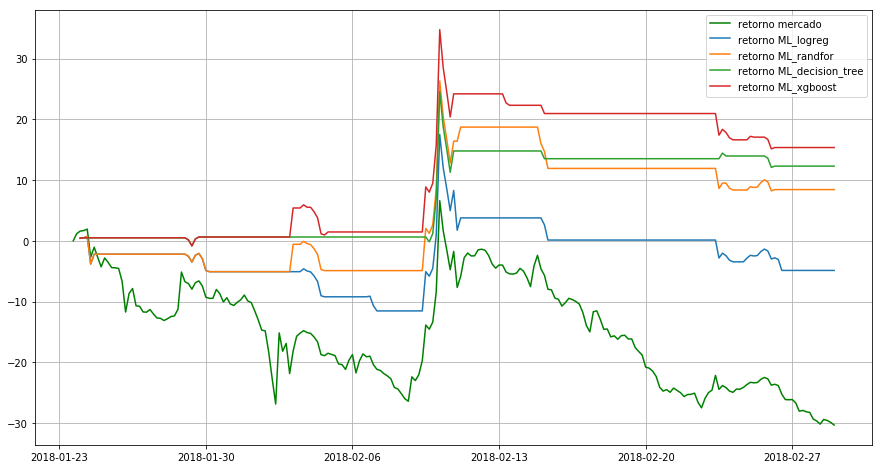

In [41]:
# regresion logistica
print "Regresion logistica:"
w_pred = logreg.predict(test[features])
#print "score:",logreg.score(train[features],train["ideal_w"])
print accuracy_score(test["ideal_w"], w_pred)

w5 = pd.DataFrame(data={"w":w_pred,"price":test["close"]})
w5["orders"] = orders(w5["w"])
w5["w"] = w5["w"].shift(1)
relativeReturn5, v5 = profit(w5)

# random forest
print "random forest:"
w_pred2 = random_forest.predict(test[features])
#print "random forest:",random_forest.score(train[features],train["ideal_w"])
print accuracy_score(test["ideal_w"], w_pred2)

w6 = pd.DataFrame(data={"w":w_pred2,"price":test["close"]})
w6["orders"] = orders(w6["w"])
w6["w"] = w6["w"].shift(1)
relativeReturn6, v6 = profit(w6)

# decision tree
print "decision_tree:"
w_pred22 = decision_tree.predict(test[features])
#print "decision_tree:",decision_tree.score(train[features],train["ideal_w"])
print accuracy_score(test["ideal_w"], w_pred22)

w62 = pd.DataFrame(data={"w":w_pred22,"price":test["close"]})
w62["orders"] = orders(w62["w"])
w62["w"] = w62["w"].shift(1)
relativeReturn62, v62 = profit(w62)

# decision xgboost
print "xgboost:"
w_pred23 = xgb.predict(test[features])
#print "decision_tree:",decision_tree.score(train[features],train["ideal_w"])
print accuracy_score(test["ideal_w"], w_pred23)

w63 = pd.DataFrame(data={"w":w_pred23,"price":test["close"]})
w63["orders"] = orders(w63["w"])
w63["w"] = w63["w"].shift(1)
relativeReturn63, v63 = profit(w63)

# knn
print "Regresion knn:"
w_pred3 = knn.predict(test[features])
#print "Regresion knn:",knn.score(train[features],train["ideal_w"])
print accuracy_score(test["ideal_w"], w_pred3)

w7 = pd.DataFrame(data={"w":w_pred3,"price":test["close"]})
w7["orders"] = orders(w7["w"])
w7["w"] = w7["w"].shift(1)
relativeReturn7, v7 = profit(w7)

# mlpc
print "Regresion mlpc:"
w_pred4 = mlpc.predict(test[features])
#print "Regresion mlpc:",mlpc.score(train[features],train["ideal_w"])
print accuracy_score(test["ideal_w"], w_pred4)

w8 = pd.DataFrame(data={"w":w_pred4,"price":test["close"]})
w8["orders"] = orders(w8["w"])
w8["w"] = w8["w"].shift(1)
relativeReturn8, v8 = profit(w8)

# rbm
print "Regresion rbm:"
w_pred5 = classifier.predict(test[features])
#print "Regresion rbm:",classifier.score(train[features],train["ideal_w"])
print accuracy_score(test["ideal_w"], w_pred5)

w9 = pd.DataFrame(data={"w":w_pred5,"price":test["close"]})
w9["orders"] = orders(w9["w"])
w9["w"] = w9["w"].shift(1)
relativeReturn9, v9 = profit(w9)


print 'Retorno del mercacdo: %s'%(marketReturn2)
"""
print 'Retorno de SMA13 VS EMA5: %s'%(relativeReturnTest*100)
print 'Retorno de Precio VS SMA20: %s'%(relativeReturn3Test*100)
print 'Retorno de Precio VS EMA5: %s'%(relativeReturn2Test*100)
print 'Retorno de ML_logreg: %s'%(relativeReturn5*100)
print 'Retorno de ML_randfor: %s'%(relativeReturn6*100)
print 'Retorno de ML_knn: %s'%(relativeReturn7*100)
"""
print 'Retorno de ML_mlpc: %s'%(relativeReturn8*100)
print 'Retorno de ML_Boltzman: %s'%(relativeReturn9*100)
print 'Retorno de ML_randfor: %s'%(relativeReturn6*100)
print 'Retorno de ML_decision_tree: %s'%(relativeReturn62*100)
print 'Retorno de ML_xgboost: %s'%(relativeReturn63*100)

plt.plot(df.index[int(len(data)*per):],cum_return2*100,'g', label='retorno mercado')
#plt.plot(df.index[int(len(data)*per):],vTest*100,'y',label='retorno EMA_5vsSMA_13')
#plt.plot(df.index[int(len(data)*per):],v3Test*100,'b',label='retorno SMA_20')
#plt.plot(df.index[int(len(data)*per):],v2Test*100,'r',label='retorno EMA_5')
plt.plot(df.index[int(len(data)*per):],v5*100,label='retorno ML_logreg')
plt.plot(df.index[int(len(data)*per):],v6*100,label='retorno ML_randfor')
plt.plot(df.index[int(len(data)*per):],v62*100,label='retorno ML_decision_tree')
plt.plot(df.index[int(len(data)*per):],v63*100,label='retorno ML_xgboost')
#plt.plot(df.index[int(len(data)*per):],v7*100,label='retorno ML_knn')
#plt.plot(df.index[int(len(data)*per):],v8*100,label='retorno ML_mlcp')
#plt.plot(df.index[int(len(data)*per):],v9*100,label='retorno ML_Botzman')

plt.legend(loc='best')
plt.grid()


In [13]:
w5.tail()

,price,w,orders,return
date,,,,
2018-02-28 08:00:00,0.000085,0.0,WAIT,-0.062823
2018-02-28 12:00:00,0.000086,0.0,WAIT,-0.062823
2018-02-28 16:00:00,0.000086,0.0,WAIT,-0.062823
2018-02-28 20:00:00,0.000086,0.0,WAIT,-0.062823
2018-03-01 00:00:00,0.000085,0.0,WAIT,-0.062823


In [14]:
from strategy import ml_logreg

# Caracteristicas sobre las que se entrenara el modelo
feature_dic = {"rsi":stock["rsi_14"],"cci":stock["cci"],"price":df["close"]}

# Creando vector de pesos utilizando estrategia de ML de regresión logística
w_logreg = ml_logreg(df["close"],per=0.9,**feature_dic)

# Calculando retorno
relativeReturn6, v6 = profit(w_logreg)

print 'Retorno de ML_strategy: %s'%(relativeReturn6*100)

Retorno de ML_strategy: 9.05754812526025


indicators.py:29: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=0,adjust=True,com=14).mean()
  roll_up1 = pd.stats.moments.ewma(up, window_length)
indicators.py:30: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,min_periods=0,adjust=True,com=14).mean()
  roll_down1 = pd.stats.moments.ewma(down.abs(), window_length)
indicators.py:42: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  roll_up2 = pd.rolling_mean(up, window_length)
indicators.py:43: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=14,center=False).mean()
  roll_down2 = pd.rolling_mean(down.abs(), window_length)


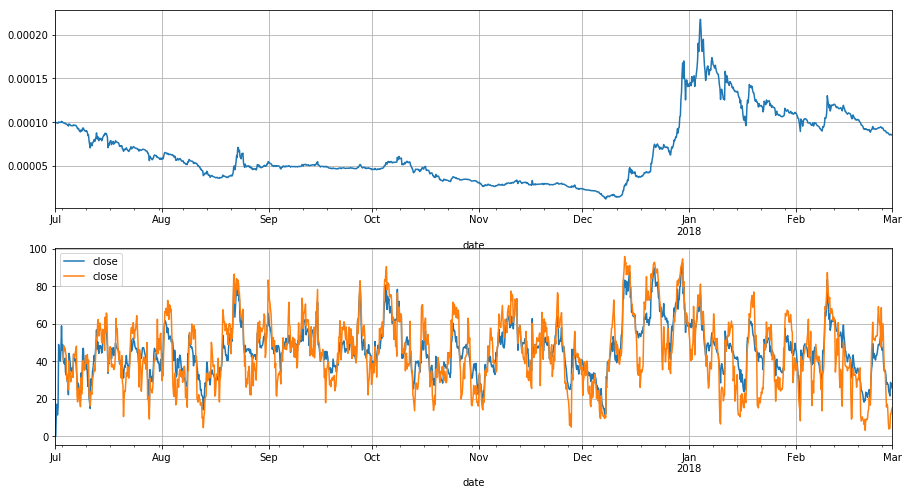

In [15]:
from indicators import rsi

RSI1, RSI2 = rsi(df["close"])

RSI1.head()

plt.subplot(211)
#plt.plot(df.index[1:],df['close'][1:],'r', label='precio')
plt.legend(loc='best')
df["close"].plot()
plt.grid()

plt.subplot(212)
RSI1.plot()
RSI2.plot()
plt.legend(loc='best')
plt.grid()